## Recommender System with CNN and Text CNN
For this model, we use the movielens data.
https://grouplens.org/datasets/movielens/
MovieLens 1M Dataset
Because only this data have users data. The data with greater size do not have that.




### Text Convolutional Neural Network
The implement come from this paper by Kim Yoon.
Convolutional Neural Networks for Sentence Classification
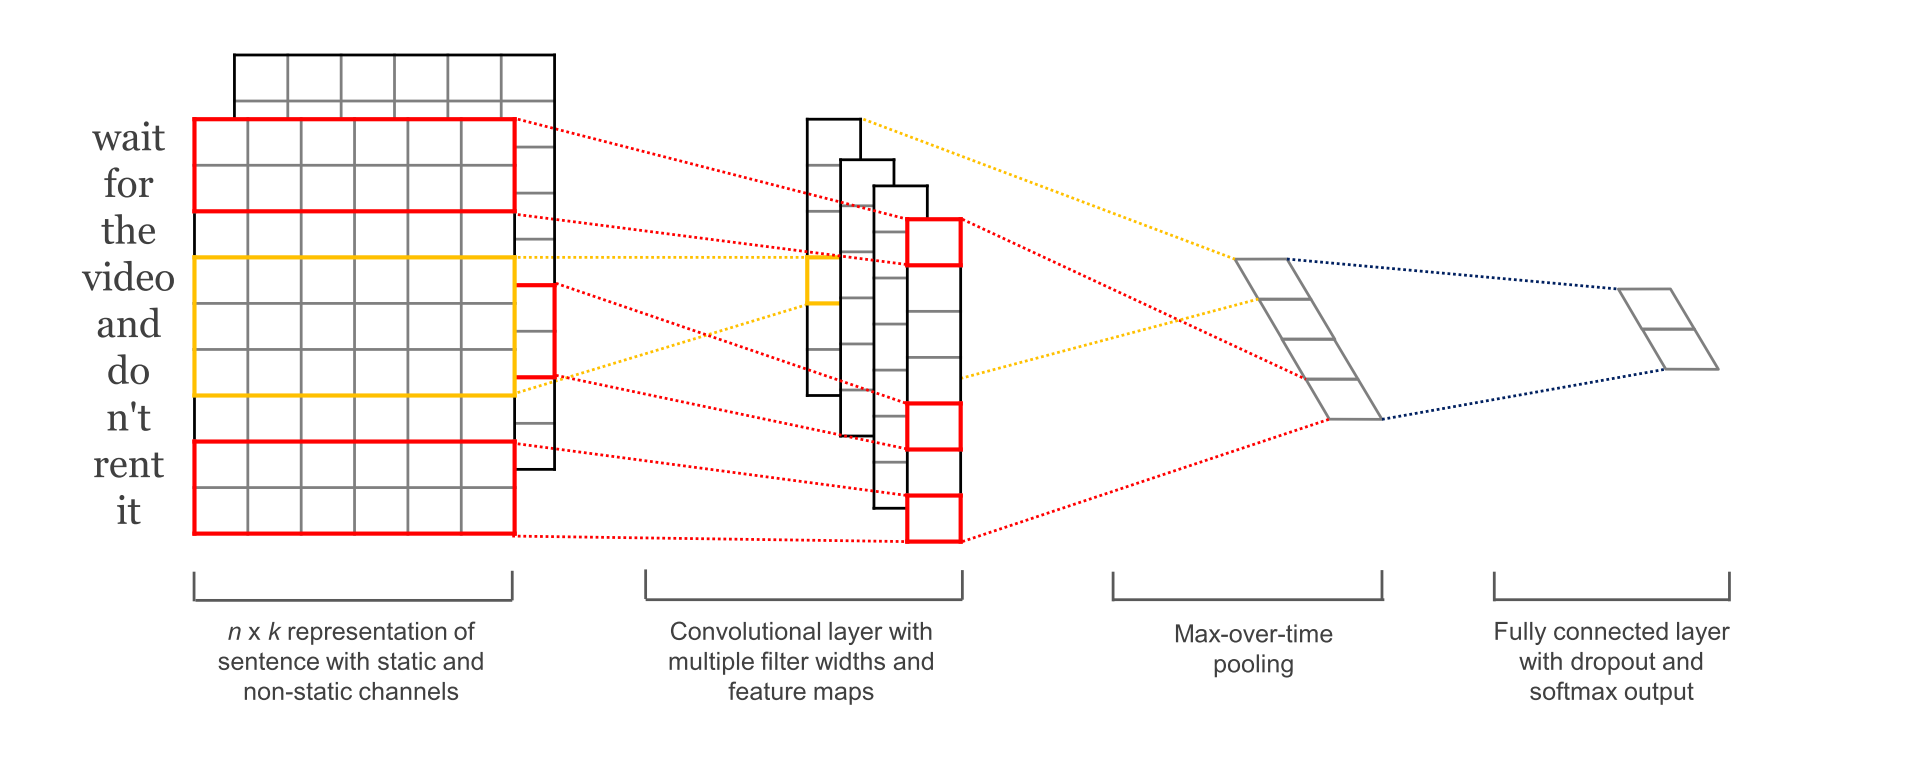
Picture from https://arxiv.org/abs/1408.5882


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import pickle
import re
from sklearn import cross_validation as cv
from collections import Counter
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time
import datetime

D:\ProgramData\Anaconda3\envs\FinalProject\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./users.dat', sep='::', header=None, names=users_title, engine = 'python')

In [3]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./movies.dat', sep='::', header=None, names=movies_title, engine = 'python')

In [4]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')

In [5]:
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
dataforview = pd.merge(pd.merge(ratings, users), movies)
dataforview.head()

,UserID,MovieID,Rating,timestamps,Gender,Age,OccupationID,Zip-code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [9]:
users_orig = users.values
movies_orig = movies.values

In [10]:
gender_map = {'F':0, 'M':1}
age_map = {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}

In [11]:
users['Gender'] = users['Gender'].map(gender_map)
users['Age'] = users['Age'].map(age_map)

In [12]:
users = users.filter(regex='UserID|Gender|Age|OccupationID')
users.head()

,UserID,Gender,Age,OccupationID
0,1,0,0,10
1,2,1,6,16
2,3,1,2,15
3,4,1,4,7
4,5,1,2,20


In [13]:
pattern = re.compile(r'^(.*)\((\d+)\)$')
title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
movies['Title'] = movies['Title'].map(title_map)

In [14]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story,Animation|Children's|Comedy
1,2,Jumanji,Adventure|Children's|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama
4,5,Father of the Bride Part II,Comedy


In [15]:
genres_dic ={'<PAD>': 0,
 'Action': 1,
 'Adventure': 2,
 'Animation': 3,
 "Children's": 4,
 'Comedy': 5,
 'Crime': 6,
 'Documentary': 7,
 'Drama': 8,
 'Fantasy': 9,
 'Film-Noir': 10,
 'Horror': 11,
 'Musical': 12,
 'Mystery': 13,
 'Romance': 14,
 'Sci-Fi': 15,
 'Thriller': 16,
 'War': 17,
 'Western': 18}

In [16]:
genres_map = {val:[genres_dic[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

In [17]:
for key in genres_map:
    for cnt in range(max(genres_dic.values()) - len(genres_map[key])):
        genres_map[key].insert(len(genres_map[key]) + cnt,genres_dic['<PAD>'])
movies['Genres'] = movies['Genres'].map(genres_map)

In [18]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story,"[3, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji,"[2, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men,"[5, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,4,Waiting to Exhale,"[5, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,Father of the Bride Part II,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
title_set = set()
for val in movies['Title'].str.split():
    title_set.update(val)    
title_set.add('<PAD>')

In [20]:
title_dic = {val:ii for ii, val in enumerate(title_set)}

In [21]:
title_count = 15
title_map = {val:[title_dic[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}

In [22]:
for key in title_map:
    for cnt in range(title_count - len(title_map[key])):
        title_map[key].insert(len(title_map[key]) + cnt,title_dic['<PAD>'])    
movies['Title'] = movies['Title'].map(title_map)

In [23]:
movies.head()

,MovieID,Title,Genres
0,1,"[4803, 3889, 1629, 1629, 1629, 1629, 1629, 162...","[3, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[3772, 1629, 1629, 1629, 1629, 1629, 1629, 162...","[2, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[2141, 1072, 456, 1629, 1629, 1629, 1629, 1629...","[5, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,4,"[568, 3009, 2042, 1629, 1629, 1629, 1629, 1629...","[5, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[3226, 3376, 4477, 3442, 2299, 2671, 1629, 162...","[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [24]:
ratings = ratings.filter(regex='UserID|MovieID|Rating')

In [25]:
data = pd.merge(pd.merge(ratings, users), movies)
data.head()

,UserID,MovieID,Rating,Gender,Age,OccupationID,Title,Genres
0,1,1193,5,0,0,10,"[1799, 5044, 2345, 4477, 2177, 1649, 1629, 162...","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1193,5,1,6,16,"[1799, 5044, 2345, 4477, 2177, 1649, 1629, 162...","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,12,1193,4,1,2,12,"[1799, 5044, 2345, 4477, 2177, 1649, 1629, 162...","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,15,1193,4,1,2,7,"[1799, 5044, 2345, 4477, 2177, 1649, 1629, 162...","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,17,1193,5,1,5,1,"[1799, 5044, 2345, 4477, 2177, 1649, 1629, 162...","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [26]:
dataforview.head()

,UserID,MovieID,Rating,timestamps,Gender,Age,OccupationID,Zip-code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [27]:
target_fields = ['Rating']
features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]

In [28]:
features = features_pd.values
targets_values = targets_pd.values

In [29]:
pickle.dump((title_count, title_set, genres_dic, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

In [30]:
title_count, title_set, genres_dic, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

In [31]:
def save_params(params):
    pickle.dump(params, open('params.p', 'wb'))
def load_params():
    return pickle.load(open('params.p', mode='rb'))

In [32]:
embed_dim = 32

In [33]:
uid_count = max(features.take(0,1)) +1

In [34]:
gender_count  = max(features.take(2,1)) + 1 
gender_count 

2

In [35]:
age_count  = max(features.take(3,1)) + 1 
age_count

7

In [36]:
job_count  = max(features.take(4,1)) + 1
job_count

21

In [37]:
movie_id_count  = max(features.take(1,1)) +1

In [38]:
movie_categories_count  = max(genres_dic.values()) + 1 
movie_categories_count 

19

In [39]:
movie_title_max = len(title_set) 
movie_title_max

5215

In [40]:
combiner = "sum"
sentences_size = title_count 
window_sizes = {2, 3, 4, 5}
filter_num = 8
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

In [41]:
# Number of Epochs
num_epochs =10
# Batch Size
batch_size = 256
# 30% of neurons will be discard in every epochs.
dropout_keep = 0.7
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 50

save_dir = './save'

In [42]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

In [43]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_count, embed_dim], -1, 1), name = "uid_embed_matrix")
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")    
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_count, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_count, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_count, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

In [44]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2) 
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 256, tf.tanh)     
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 256])
    return user_combine_layer, user_combine_layer_flat

In [45]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_count, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

In [46]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_count, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    return movie_categories_embed_layer

In [47]:
def get_movie_cnn_layer(movie_titles):
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

In [48]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 256, tf.tanh)    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 256])
    return movie_combine_layer, movie_combine_layer_flat

In [49]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer)
    with tf.name_scope("inference"):
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)
    with tf.name_scope("loss"):
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)

In [50]:
def get_batches(xs, ys, batch_size):
    for start in range(0, len(xs), batch_size):
        end = min(start + batch_size, len(xs))
        yield xs[start:end], ys[start:end]

In [51]:
losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
    
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
    
    loss_summary = tf.summary.scalar("loss", loss)
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        train_X,test_X, train_y, test_y = cv.train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories, 
                movie_titles: titles, 
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  
                movie_titles: titles,  
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))
    saver.save(sess, save_dir)  
    print('Model Trained and Saved')

Writing to C:\Users\Hao\Desktop\FinalProject\runs\1524556421

2018-04-24T02:53:46.044854: Epoch   0 Batch    0/3125   train_loss = 16.376
2018-04-24T02:53:47.878596: Epoch   0 Batch   50/3125   train_loss = 2.133
2018-04-24T02:53:49.696954: Epoch   0 Batch  100/3125   train_loss = 1.940
2018-04-24T02:53:51.657699: Epoch   0 Batch  150/3125   train_loss = 1.643
2018-04-24T02:53:53.467306: Epoch   0 Batch  200/3125   train_loss = 1.620
2018-04-24T02:53:55.285116: Epoch   0 Batch  250/3125   train_loss = 1.277
2018-04-24T02:53:57.124423: Epoch   0 Batch  300/3125   train_loss = 1.460
2018-04-24T02:53:58.996294: Epoch   0 Batch  350/3125   train_loss = 1.264
2018-04-24T02:54:00.812626: Epoch   0 Batch  400/3125   train_loss = 1.146
2018-04-24T02:54:02.638008: Epoch   0 Batch  450/3125   train_loss = 1.279
2018-04-24T02:54:04.461534: Epoch   0 Batch  500/3125   train_loss = 1.033
2018-04-24T02:54:06.278926: Epoch   0 Batch  550/3125   train_loss = 1.229
2018-04-24T02:54:08.112338: Epoch   0

2018-04-24T02:56:42.830686: Epoch   1 Batch 1525/3125   train_loss = 0.913
2018-04-24T02:56:44.654843: Epoch   1 Batch 1575/3125   train_loss = 1.048
2018-04-24T02:56:46.488792: Epoch   1 Batch 1625/3125   train_loss = 1.227
2018-04-24T02:56:48.348184: Epoch   1 Batch 1675/3125   train_loss = 0.952
2018-04-24T02:56:50.241152: Epoch   1 Batch 1725/3125   train_loss = 0.969
2018-04-24T02:56:52.063385: Epoch   1 Batch 1775/3125   train_loss = 1.007
2018-04-24T02:56:53.885263: Epoch   1 Batch 1825/3125   train_loss = 1.130
2018-04-24T02:56:55.725133: Epoch   1 Batch 1875/3125   train_loss = 1.159
2018-04-24T02:56:57.550261: Epoch   1 Batch 1925/3125   train_loss = 0.934
2018-04-24T02:56:59.412206: Epoch   1 Batch 1975/3125   train_loss = 1.079
2018-04-24T02:57:01.248161: Epoch   1 Batch 2025/3125   train_loss = 1.057
2018-04-24T02:57:03.171361: Epoch   1 Batch 2075/3125   train_loss = 1.152
2018-04-24T02:57:05.026910: Epoch   1 Batch 2125/3125   train_loss = 1.034
2018-04-24T02:57:06.85514

2018-04-24T02:59:41.801419: Epoch   2 Batch 3100/3125   train_loss = 1.069
2018-04-24T02:59:42.950598: Epoch   2 Batch   38/781   test_loss = 0.902
2018-04-24T02:59:43.296050: Epoch   2 Batch   88/781   test_loss = 0.763
2018-04-24T02:59:43.624424: Epoch   2 Batch  138/781   test_loss = 1.033
2018-04-24T02:59:43.948568: Epoch   2 Batch  188/781   test_loss = 0.873
2018-04-24T02:59:44.261901: Epoch   2 Batch  238/781   test_loss = 0.946
2018-04-24T02:59:44.575255: Epoch   2 Batch  288/781   test_loss = 0.869
2018-04-24T02:59:44.890602: Epoch   2 Batch  338/781   test_loss = 0.930
2018-04-24T02:59:45.204450: Epoch   2 Batch  388/781   test_loss = 0.904
2018-04-24T02:59:45.516280: Epoch   2 Batch  438/781   test_loss = 0.985
2018-04-24T02:59:45.829613: Epoch   2 Batch  488/781   test_loss = 0.896
2018-04-24T02:59:46.142445: Epoch   2 Batch  538/781   test_loss = 0.785
2018-04-24T02:59:46.455276: Epoch   2 Batch  588/781   test_loss = 0.856
2018-04-24T02:59:46.769613: Epoch   2 Batch  638/

2018-04-24T03:02:22.366653: Epoch   4 Batch  850/3125   train_loss = 0.993
2018-04-24T03:02:24.264320: Epoch   4 Batch  900/3125   train_loss = 0.874
2018-04-24T03:02:26.105245: Epoch   4 Batch  950/3125   train_loss = 0.873
2018-04-24T03:02:27.962183: Epoch   4 Batch 1000/3125   train_loss = 0.999
2018-04-24T03:02:29.815107: Epoch   4 Batch 1050/3125   train_loss = 0.815
2018-04-24T03:02:31.715160: Epoch   4 Batch 1100/3125   train_loss = 0.875
2018-04-24T03:02:33.559062: Epoch   4 Batch 1150/3125   train_loss = 0.824
2018-04-24T03:02:35.402938: Epoch   4 Batch 1200/3125   train_loss = 1.017
2018-04-24T03:02:37.261908: Epoch   4 Batch 1250/3125   train_loss = 0.892
2018-04-24T03:02:39.130877: Epoch   4 Batch 1300/3125   train_loss = 0.853
2018-04-24T03:02:40.996839: Epoch   4 Batch 1350/3125   train_loss = 0.839
2018-04-24T03:02:42.843722: Epoch   4 Batch 1400/3125   train_loss = 0.934
2018-04-24T03:02:44.733379: Epoch   4 Batch 1450/3125   train_loss = 0.886
2018-04-24T03:02:46.60387

2018-04-24T03:05:23.917951: Epoch   5 Batch 2425/3125   train_loss = 0.837
2018-04-24T03:05:25.758849: Epoch   5 Batch 2475/3125   train_loss = 0.940
2018-04-24T03:05:27.590613: Epoch   5 Batch 2525/3125   train_loss = 0.775
2018-04-24T03:05:29.414394: Epoch   5 Batch 2575/3125   train_loss = 0.780
2018-04-24T03:05:31.243257: Epoch   5 Batch 2625/3125   train_loss = 1.006
2018-04-24T03:05:33.139298: Epoch   5 Batch 2675/3125   train_loss = 0.803
2018-04-24T03:05:34.987316: Epoch   5 Batch 2725/3125   train_loss = 0.925
2018-04-24T03:05:36.846227: Epoch   5 Batch 2775/3125   train_loss = 0.872
2018-04-24T03:05:38.681106: Epoch   5 Batch 2825/3125   train_loss = 0.804
2018-04-24T03:05:40.529129: Epoch   5 Batch 2875/3125   train_loss = 0.837
2018-04-24T03:05:42.372024: Epoch   5 Batch 2925/3125   train_loss = 0.866
2018-04-24T03:05:44.207931: Epoch   5 Batch 2975/3125   train_loss = 0.756
2018-04-24T03:05:46.115046: Epoch   5 Batch 3025/3125   train_loss = 0.871
2018-04-24T03:05:47.96393

2018-04-24T03:08:05.605828: Epoch   7 Batch  175/3125   train_loss = 0.831
2018-04-24T03:08:07.487345: Epoch   7 Batch  225/3125   train_loss = 0.771
2018-04-24T03:08:09.386949: Epoch   7 Batch  275/3125   train_loss = 0.709
2018-04-24T03:08:11.289009: Epoch   7 Batch  325/3125   train_loss = 0.867
2018-04-24T03:08:13.219640: Epoch   7 Batch  375/3125   train_loss = 0.863
2018-04-24T03:08:15.127790: Epoch   7 Batch  425/3125   train_loss = 0.866
2018-04-24T03:08:17.092021: Epoch   7 Batch  475/3125   train_loss = 0.818
2018-04-24T03:08:19.009672: Epoch   7 Batch  525/3125   train_loss = 0.906
2018-04-24T03:08:20.881467: Epoch   7 Batch  575/3125   train_loss = 0.922
2018-04-24T03:08:22.825717: Epoch   7 Batch  625/3125   train_loss = 0.798
2018-04-24T03:08:24.661413: Epoch   7 Batch  675/3125   train_loss = 0.753
2018-04-24T03:08:26.524341: Epoch   7 Batch  725/3125   train_loss = 0.799
2018-04-24T03:08:28.387124: Epoch   7 Batch  775/3125   train_loss = 0.761
2018-04-24T03:08:30.29823

2018-04-24T03:11:09.287634: Epoch   8 Batch 1800/3125   train_loss = 0.810
2018-04-24T03:11:11.169660: Epoch   8 Batch 1850/3125   train_loss = 0.789
2018-04-24T03:11:13.041372: Epoch   8 Batch 1900/3125   train_loss = 0.713
2018-04-24T03:11:14.881786: Epoch   8 Batch 1950/3125   train_loss = 0.771
2018-04-24T03:11:16.739479: Epoch   8 Batch 2000/3125   train_loss = 0.977
2018-04-24T03:11:18.680949: Epoch   8 Batch 2050/3125   train_loss = 0.838
2018-04-24T03:11:20.551910: Epoch   8 Batch 2100/3125   train_loss = 0.786
2018-04-24T03:11:22.418428: Epoch   8 Batch 2150/3125   train_loss = 0.842
2018-04-24T03:11:24.261431: Epoch   8 Batch 2200/3125   train_loss = 0.797
2018-04-24T03:11:26.100719: Epoch   8 Batch 2250/3125   train_loss = 0.928
2018-04-24T03:11:27.961328: Epoch   8 Batch 2300/3125   train_loss = 0.856
2018-04-24T03:11:29.795510: Epoch   8 Batch 2350/3125   train_loss = 0.933
2018-04-24T03:11:31.636173: Epoch   8 Batch 2400/3125   train_loss = 0.891
2018-04-24T03:11:33.47948

2018-04-24T03:14:01.616168: Epoch   9 Batch  271/781   test_loss = 0.874
2018-04-24T03:14:01.927997: Epoch   9 Batch  321/781   test_loss = 0.874
2018-04-24T03:14:02.237821: Epoch   9 Batch  371/781   test_loss = 0.707
2018-04-24T03:14:02.555666: Epoch   9 Batch  421/781   test_loss = 0.844
2018-04-24T03:14:02.865991: Epoch   9 Batch  471/781   test_loss = 0.810
2018-04-24T03:14:03.177319: Epoch   9 Batch  521/781   test_loss = 0.839
2018-04-24T03:14:03.490151: Epoch   9 Batch  571/781   test_loss = 0.741
2018-04-24T03:14:03.801478: Epoch   9 Batch  621/781   test_loss = 0.878
2018-04-24T03:14:04.114310: Epoch   9 Batch  671/781   test_loss = 0.809
2018-04-24T03:14:04.425137: Epoch   9 Batch  721/781   test_loss = 0.776
2018-04-24T03:14:04.733958: Epoch   9 Batch  771/781   test_loss = 0.657
Model Trained and Saved


In [52]:
save_params((save_dir))
load_dir = load_params()

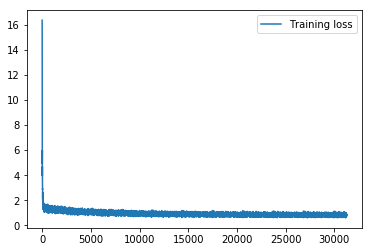

In [53]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

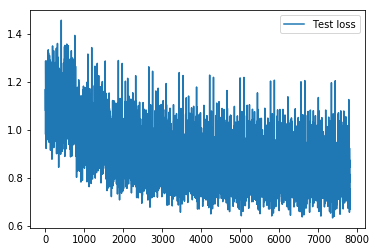

In [54]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

In [55]:
def get_tensors(loaded_graph):
    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") 
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat

In [56]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  
    with tf.Session(graph=loaded_graph) as sess:  
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  
              movie_titles: titles,  
              dropout_keep_prob: 1}    
        # Get Prediction
        inference_val = sess.run([inference], feed)      
        return (inference_val)

In [57]:
rating_movie(571, 2018)

INFO:tensorflow:Restoring parameters from ./save


[array([[ 3.81016231]], dtype=float32)]

In [58]:
loaded_graph = tf.Graph()  
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)
        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)
        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  
            movie_titles: titles, 
            dropout_keep_prob: 1}
        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)
pickle.dump((np.array(movie_matrics).reshape(-1, 256)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [59]:
loaded_graph = tf.Graph()  
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:
        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}
        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)
pickle.dump((np.array(users_matrics).reshape(-1, 256)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [60]:
def recommend_same_type_movie(movie_id_val, top_k = 5):
    loaded_graph = tf.Graph()  
    with tf.Session(graph=loaded_graph) as sess:  
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 256])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
        print("The movie you take：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("Recommend you to take：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != top_k:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])        
        return results

In [61]:
recommend_same_type_movie(1, 10)

INFO:tensorflow:Restoring parameters from ./save
The movie you take：[1 'Toy Story (1995)' "Animation|Children's|Comedy"]
Recommend you to take：
0
[1 'Toy Story (1995)' "Animation|Children's|Comedy"]
3682
[3751 'Chicken Run (2000)' "Animation|Children's|Comedy"]
2692
[2761 'Iron Giant, The (1999)' "Animation|Children's"]
903
[915 'Sabrina (1954)' 'Comedy|Romance']
1287
[1307 'When Harry Met Sally... (1989)' 'Comedy|Romance']
2286
[2355 "Bug's Life, A (1998)" "Animation|Children's|Comedy"]
592
[596 'Pinocchio (1940)' "Animation|Children's"]
1171
[1188 'Strictly Ballroom (1992)' 'Comedy|Romance']
2068
[2137 "Charlotte's Web (1973)" "Animation|Children's"]
924
[936 'Ninotchka (1939)' 'Comedy|Romance']


{0, 592, 903, 924, 1171, 1287, 2068, 2286, 2692, 3682}

In [62]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):
    loaded_graph = tf.Graph()  
    with tf.Session(graph=loaded_graph) as sess:  
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 256])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())    
        print("Recommend：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != top_k:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        return results

In [63]:
recommend_your_favorite_movie(571, 10)

INFO:tensorflow:Restoring parameters from ./save
Recommend：
257
[260 'Star Wars: Episode IV - A New Hope (1977)'
 'Action|Adventure|Fantasy|Sci-Fi']
900
[912 'Casablanca (1942)' 'Drama|Romance|War']
740
[750
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'
 'Sci-Fi|War']
901
[913 'Maltese Falcon, The (1941)' 'Film-Noir|Mystery']
1194
[1212 'Third Man, The (1949)' 'Mystery|Thriller']
847
[858 'Godfather, The (1972)' 'Action|Crime|Drama']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']
892
[904 'Rear Window (1954)' 'Mystery|Thriller']
1950
[2019 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'
 'Action|Drama']
735
[745 'Close Shave, A (1995)' 'Animation|Comedy|Thriller']


{257, 315, 735, 740, 847, 892, 900, 901, 1194, 1950}

In [64]:
# the movies of the guys who have take this movie have also take
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 5):
    loaded_graph = tf.Graph()  
    with tf.Session(graph=loaded_graph) as sess:  
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 256])
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
        print("The movie you take：{}".format(movies_orig[movieid2idx[movie_id_val]]))        
        print("Who like this moive: {}".format(users_orig[favorite_user_id-1]))
        probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 256])
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
        p = np.argmax(sim, 1)
        print("The moive they also take：")
        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])        
        return results

In [65]:
recommend_other_favorite_movie( 1, 20)

INFO:tensorflow:Restoring parameters from ./save
The movie you take：[1 'Toy Story (1995)' "Animation|Children's|Comedy"]
Who like this moive: [[335 'M' 35 18 '55434']
 [4800 'M' 18 4 '80521']
 [5002 'M' 25 17 '90505']
 [4460 'M' 25 14 '70005']
 [232 'M' 25 20 '55408']
 [1170 'M' 56 3 '10023']
 [3031 'M' 18 4 '48135']
 [446 'F' 50 0 '55042']
 [4043 'F' 25 15 '94002']
 [4775 'M' 25 17 '23462']
 [3780 'M' 1 0 '46979']
 [277 'F' 35 1 '98126']
 [1745 'M' 45 0 '94114']
 [4200 'M' 45 7 '10543']
 [371 'M' 18 4 '02141']
 [566 'M' 25 17 '92122']
 [100 'M' 35 17 '95401']
 [5861 'F' 50 1 '98499']
 [2338 'M' 45 17 '13152']
 [3901 'M' 18 14 '85282']]
The moive they also take：
49
[50 'Usual Suspects, The (1995)' 'Crime|Thriller']
1196
[1214 'Alien (1979)' 'Action|Horror|Sci-Fi|Thriller']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']
907
[919 'Wizard of Oz, The (1939)' "Adventure|Children's|Drama|Musical"]
1950
[2019 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'
 'Action

{49, 315, 907, 1196, 1950}